# Libraries

In [23]:
import h5py
import torch

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from sklearn.metrics  import r2_score
from glob             import glob

import matplotlib.pyplot as plt
import scipy.signal      as signal
import torch.nn          as nn
import numpy  			 as np
import pandas 		     as pd


# ECG Definitions

ECG metadata

In [24]:
samplingFrequency = 400

ECG file headers

In [25]:
ecgHeaders = [
	"LI", 
	"LII", 
	"LIII", 
	"aVR", 
	"aVL",
	"aVF", 
	"V1",
	"V2",
	"V3",
	"V4",
	"V5",
	"V6"
]

ECG plot definitions

In [26]:
ecgPlotHeaders = [
	"LI", "aVR", "V1", "V4",
	"LII", "aVL", "V2", "V5",
	"LIII", "aVF", "V3", "V6"
]

ecgPlotColors = {
	"LI":   "seagreen",
	"aVR":  "black",
	"V1":   "gold",
	"V4":   "orangered",
	"LII":  "cornflowerblue",
	"aVL":  "seagreen",
	"V2":   "gold",
	"V5":   "crimson",
	"LIII": "cornflowerblue",
	"aVF":  "cornflowerblue",
	"V3":   "orangered",
	"V6":   "crimson"
}

# The Dataset: CODE-15

Metadata

In [27]:
dataFolder = "../../../data/CODE15/hdf5/"

In [28]:
ecgFeatures = [
	"LI", 
	"aVF", 
	"V2"
]

ecgFeaturesIndexes = [ecgHeaders.index(derivation) for derivation in ecgFeatures]
ecgFeaturesIndexes

[0, 5, 7]

In [29]:
ecgTarget = [
	"LII", 
	"LIII", 
	"aVR", 
	"aVL",
	"V1",
	"V3",
	"V4",
	"V5",
	"V6"
]

ecgTargetIndexes = [ecgHeaders.index(derivation) for derivation in ecgTarget]
ecgTargetIndexes

[1, 2, 3, 4, 6, 8, 9, 10, 11]

Dataset class

In [30]:
class Code15Dataset(Dataset):
	def __init__(self, hdf5Files, features, target, transform):
		
		super().__init__()
		
		self.hdf5Files = hdf5Files
		self.indexMap  = []
		self.features  = features
		self.target    = target
		self.transform = transform


		for fileIndex, path in enumerate(self.hdf5Files):
			
			with h5py.File(path, "r") as f:
				samplesCount = f['exam_id'].shape[0]
				
				self.indexMap.extend([(fileIndex, i) for i in range(samplesCount)])

	def __len__(self):
		return len(self.indexMap)

	def __getitem__(self, idx):

		fileIndex, examIdx = self.indexMap[idx]
		hdf5File           = self.hdf5Files[fileIndex]

		with h5py.File(hdf5File, "r") as file:
			tracing = np.array(file['tracings'][examIdx])

		tracing = self.transform(tracing)

		X = tracing[:, self.features]
		X = torch.tensor(X, dtype = torch.float32)

		Y = tracing[:, self.target]
		Y = torch.tensor(Y, dtype = torch.float32)

		return X, Y


Transform Function

- highpass butterworth filter with $ f_c = 1$ Hz
- Truncation in the tails of $ N = 600  $ samples
- Gain of 5
- Normalization with z-score

In [31]:
def transform(ecg):
	b, a = signal.butter(
		N     = 1, 
		Wn    = 1, 
		btype = 'high', 
		fs    = samplingFrequency
	)
	
	ecgFiltred  = signal.filtfilt(b, a, ecg, axis = 0)
	ecgWithGain = 5 * ecgFiltred
	ecgClean    = ecgWithGain[600: -600, :]

	ecgMean = np.mean(ecgClean, axis = 0, keepdims = True)
	ecgStd  = np.std(ecgClean,  axis = 0, keepdims = True) + 1e-8

	ecgNormalized = (ecgClean - ecgMean) / ecgStd

	return ecgNormalized


Holdout dataset

In [32]:
dataset = Code15Dataset(
	hdf5Files = glob(f"{dataFolder}/*.hdf5")[:-9],
	features  = ecgFeaturesIndexes,
	target    = ecgTargetIndexes,	
	transform = transform
)

In [33]:
dataset[0][0].shape, dataset[0][1].shape 

(torch.Size([2896, 3]), torch.Size([2896, 9]))

In [34]:
len(dataset)

20001

In [35]:
generator = torch.Generator().manual_seed(14)

In [36]:
trainRatio = 0.80

trainSize = int(trainRatio * len(dataset))
testSize  = len(dataset) - trainSize

print("Train dataset Len =", trainSize)
print("Train dataset Len =", testSize)

Train dataset Len = 16000
Train dataset Len = 4001


In [37]:
trainDataset, testDataset = random_split(
	dataset = dataset,
	lengths = [trainSize, testSize]
)

Dataloaders

In [38]:
trainDataloader = DataLoader(
	dataset     = trainDataset,
	batch_size  = 32,
	shuffle     = True,
	num_workers = 4

)

testDataloader = DataLoader(
	dataset     = testDataset,
	batch_size  = 32,
	shuffle     = False,
	num_workers = 4

)

In [39]:
print("X shape =", dataset[0][0].shape)
print("Y shape =", dataset[0][1].shape)

X shape = torch.Size([2896, 3])
Y shape = torch.Size([2896, 9])


# Model definition

In [40]:
# class ECGReconstructor(nn.Module):
	
# 	def __init__(self, latentDim):
# 		super(ECGReconstructor, self).__init__()

# 		self.encoderInputDim  = 2896 * 3   # 8688
# 		self.decoderOutputDim = 2896 * 9   # 26064
# 		self.hiddenDim = 1024
# 		self.latentDim = latentDim

# 		self.encoder = nn.Sequential(
# 			nn.Flatten(),
# 			nn.Linear(self.encoderInputDim, 2048),
# 			nn.LeakyReLU(0.2),
# 			nn.Linear(2048, 1024),
# 			nn.LeakyReLU(0.2),
# 			nn.Linear(1024, self.latentDim),
# 			nn.LeakyReLU(0.2)
# 		)

# 		self.mean   = nn.Linear(self.latentDim, self.latentDim)
# 		self.logvar = nn.Linear(self.latentDim, self.latentDim)

# 		self.decoder = nn.Sequential(
# 			nn.Linear(self.latentDim, 1024),
# 			nn.LeakyReLU(0.2),
# 			nn.Linear(1024, 2048),
# 			nn.LeakyReLU(0.2),
# 			nn.Linear(2048, self.decoderOutputDim),
# 			nn.Unflatten(1, (2896, 9))
# 		)

# 	def encode(self, X):
		
# 		X      = self.encoder(X)
# 		mean   = self.mean(X)
# 		logvar = self.logvar(X)
		
# 		return mean, logvar
	
# 	def decode(self, X):
# 		return self.decoder(X)
	
# 	def reparameterization(self, mean, logvar):
		
# 		epsilon = torch.randn_like(logvar).to(logvar.device)
		
# 		return mean + torch.exp(logvar / 2) * epsilon
	
# 	def forward(self, X):
		
# 		mean, logvar = self.encode(X)
# 		z            = self.reparameterization(mean, logvar)
# 		YHat         = self.decode(z)
		
# 		return YHat, mean, logvar

class ECGReconstructor(nn.Module):
	def __init__(self, latentDim=256):
		super(ECGReconstructor, self).__init__()

		self.latentDim = latentDim

		self.encoder = nn.Sequential(
			nn.Conv1d(3, 32, kernel_size=5, stride=2, padding=2),  # (batch, 32, 1448)
			nn.LeakyReLU(0.2),
			nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2), # (batch, 64, 724)
			nn.LeakyReLU(0.2),
			nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2), # (batch, 128, 362)
			nn.LeakyReLU(0.2),
			nn.Conv1d(128, 256, kernel_size=5, stride=2, padding=2), # (batch, 256, 181)
			nn.LeakyReLU(0.2),
		)

		self.flattenedSize = 256 * 181

		# Bottleneck
		self.fc_mu 	   = nn.Linear(self.flattenedSize, latentDim)
		self.fc_logvar = nn.Linear(self.flattenedSize, latentDim)

		self.fc_decode = nn.Linear(latentDim, self.flattenedSize)

		self.decoder = nn.Sequential(
			nn.ConvTranspose1d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1),  # (batch, 128, 362)
			nn.LeakyReLU(0.2),
			nn.ConvTranspose1d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1),   # (batch, 64, 724)
			nn.LeakyReLU(0.2),
			nn.ConvTranspose1d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1),    # (batch, 32, 1448)
			nn.LeakyReLU(0.2),
			nn.ConvTranspose1d(32, 9, kernel_size=5, stride=2, padding=2, output_padding=1),     # (batch, 9, 2896)
		)

	def encode(self, X):
		X = self.encoder(X)
		X = torch.flatten(X, start_dim = 1)

		mu 	   = self.fc_mu(X)
		logvar = self.fc_logvar(X)
		
		return mu, logvar

	def reparameterize(self, mu, logvar):
		
		std = torch.exp(0.5 * logvar)
		eps = torch.randn_like(std)
		
		return mu + eps * std

	def decode(self, Z):
		Y = self.fc_decode(Z)
		Y = Y.view(-1, 256, 181)
		Y = self.decoder(Y)
		Y = Y.permute(0, 2, 1)
		
		return Y

	def forward(self, X):
		X = X.permute(0, 2, 1)

		mu, logvar = self.encode(X)
		Z 		   = self.reparameterize(mu, logvar)
		YHat 	   = self.decode(Z)

		return YHat, mu, logvar

# Training

Metadata

In [41]:
def vaeLoss(Y, yHat, mean, logvar):
	
	reproductionLoss = nn.functional.mse_loss(yHat, Y)
	KLD 			 = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp()) / Y.shape[0]
	KLD 			 = 1e-3 * KLD

	return reproductionLoss + KLD


In [42]:
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = ECGReconstructor(latentDim = 256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = vaeLoss
epochs    = 20

print(device)

cuda


Run

In [43]:
trainingLoss = []

In [44]:
model.train()

for epoch in range(epochs):
	totalLoss = 0

	for X, Y in trainDataloader:
		X, Y = X.to(device), Y.to(device)

		YHat, mean, logvar  = model(X)
		loss 				= criterion(Y, YHat, mean, logvar)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		totalLoss += loss.item()

	trainingLoss.append(totalLoss / len(trainDataloader))

	print(f"Epoch {epoch + 1}: loss = {trainingLoss[-1]:.4f}")

Epoch 1: loss = 0.9019
Epoch 2: loss = 0.6581
Epoch 3: loss = 0.5845
Epoch 4: loss = 0.5550
Epoch 5: loss = 0.5374
Epoch 6: loss = 0.5228
Epoch 7: loss = 0.5117
Epoch 8: loss = 0.4971
Epoch 9: loss = 0.4848
Epoch 10: loss = 0.4753
Epoch 11: loss = 0.4676
Epoch 12: loss = 0.4587
Epoch 13: loss = 0.4521
Epoch 14: loss = 0.4450
Epoch 15: loss = 0.4405
Epoch 16: loss = 0.4343
Epoch 17: loss = 0.4298
Epoch 18: loss = 0.4254
Epoch 19: loss = 0.4209
Epoch 20: loss = 0.4149


Loss along the epochs

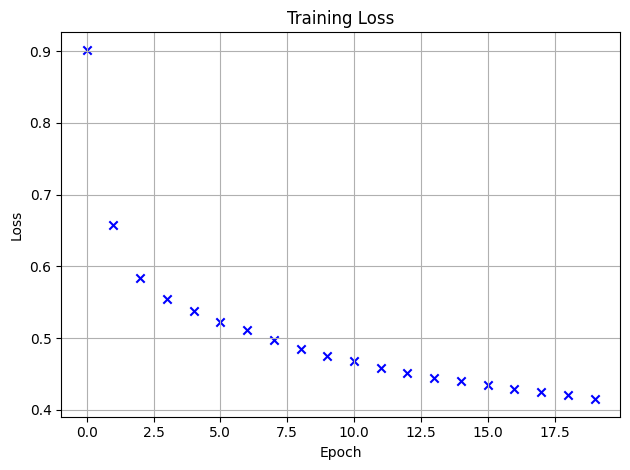

In [45]:
plt.scatter(range(epochs), trainingLoss, c = "blue", marker = "x")

plt.title("Training Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.grid()
plt.tight_layout()
plt.show()

# Test

In [46]:
model.eval()

testLoss = 0
testR2   = 0

totalSamples = 0

with torch.no_grad():
	for X, Y in testDataloader:
		X, Y       =  X.to(device), Y.to(device)

		YHat, mean, logvar  = model(X)
		loss 				= criterion(Y, YHat, mean, logvar)

		YFlat    = Y.cpu().numpy().reshape(-1, Y.shape[-1])
		YHatFlat = YHat.cpu().numpy().reshape(-1, YHat.shape[-1])

		testLoss += loss.item()
		testR2   += r2_score(YFlat, YHatFlat) * YFlat.shape[0]

		totalSamples += YFlat.shape[0]

testR2 /= totalSamples

print(f"Test Loss: {testLoss:.4f}")
print(f"Test R^2:  {testR2:.4f}")


Test Loss: 60.1066
Test R^2:  0.6527


# Ploting

Ploting functions

In [47]:
def plotECG(ecg, headers, colors): 
	figure, axes = plt.subplots(
		nrows   = 3,
		ncols   = 4,
		sharex  = True,
		figsize = (16, 9)
	)

	figure.suptitle("ECG 12-Lead")
	figure.supxlabel("Sample")
	figure.supylabel("Dpp")

	axes = axes.flatten()

	for idx, header in enumerate(headers):
		axes[idx].plot(ecg[header], color = colors[header])
		axes[idx].set_title(f"{header}")
	

	plt.tight_layout(pad = 1.5)

	plt.show()

	plt.close()

In [48]:
def comparativeFullEcgPlot(ecgOring, ecgRec, headers):
	figure, axes = plt.subplots(
		nrows   = 3,
		ncols   = 4,
		sharex  = True,
		figsize = (16, 9)
	)

	figure.suptitle("Comparison: ECG 12-Lead")
	figure.supxlabel("Sample")
	figure.supylabel("Dpp")

	axes = axes.flatten()

	for idx, header in enumerate(headers):
		corr = np.round(ecgOring[header].corr(ecgRec[header]), 3)
		r2   = np.round(r2_score(ecgOring[header], ecgRec[header]), 3)

		axes[idx].plot(
			ecgOring[header], 
			color = "blue", 
			alpha = 0.75
		)
		axes[idx].plot(
			ecgRec[header], 
			color = "red", 
			alpha = 0.75
		)

		axes[idx].set_title(f"{header} CORR = {corr} r2 = {r2}")
	

	plt.tight_layout(pad = 1.5)

	plt.show()

	plt.close()

Extract a sample ECG from dataset

In [49]:
sampleECGFeaturesTensor, sampleECGTargetTensor = dataset[32]

sampleECGFeatures = pd.DataFrame(
	columns = ecgFeatures,
	data    = sampleECGFeaturesTensor
)

sampleECGTarget = pd.DataFrame(
	columns = ecgTarget,
	data    = sampleECGTargetTensor
)

sampleECG = pd.concat(
	[sampleECGFeatures, sampleECGTarget],
	axis = 'columns'
)

sampleECG.head()


,LI,aVF,V2,LII,LIII,aVR,aVL,V1,V3,V4,V5,V6
0,-0.298292,-0.162364,-0.061621,-0.301953,0.089561,0.306154,-0.229197,0.499286,-0.077974,-0.116472,-1.662887,0.032942
1,-0.391689,-0.153561,-0.060087,-0.336523,0.194455,0.396870,-0.333652,0.499421,-0.075353,-0.116203,-1.634202,0.042673
2,-0.460769,-0.172363,-0.063119,-0.379945,0.249162,0.450773,-0.421214,0.442731,-0.087725,-0.122040,-1.615626,0.018341
3,-0.506925,-0.158735,-0.060091,-0.412026,0.281781,0.481854,-0.485428,0.403982,-0.098776,-0.113954,-1.589664,0.002749
4,-0.523488,-0.171819,-0.060715,-0.448528,0.261466,0.530101,-0.482964,0.407905,-0.093453,-0.112289,-1.557968,0.045672


In [50]:
with torch.no_grad():
	sampleECGPredicted, _, _ = model(sampleECGFeaturesTensor.unsqueeze(0).to(device))
	sampleECGPredicted 		 = sampleECGPredicted.squeeze(0).detach().cpu().numpy()


sampleECGPredicted = pd.DataFrame(
	columns=ecgTarget,
	data=sampleECGPredicted
)

sampleECGReconstructed = pd.concat(
	[sampleECGFeatures, sampleECGPredicted],
	axis='columns'
)

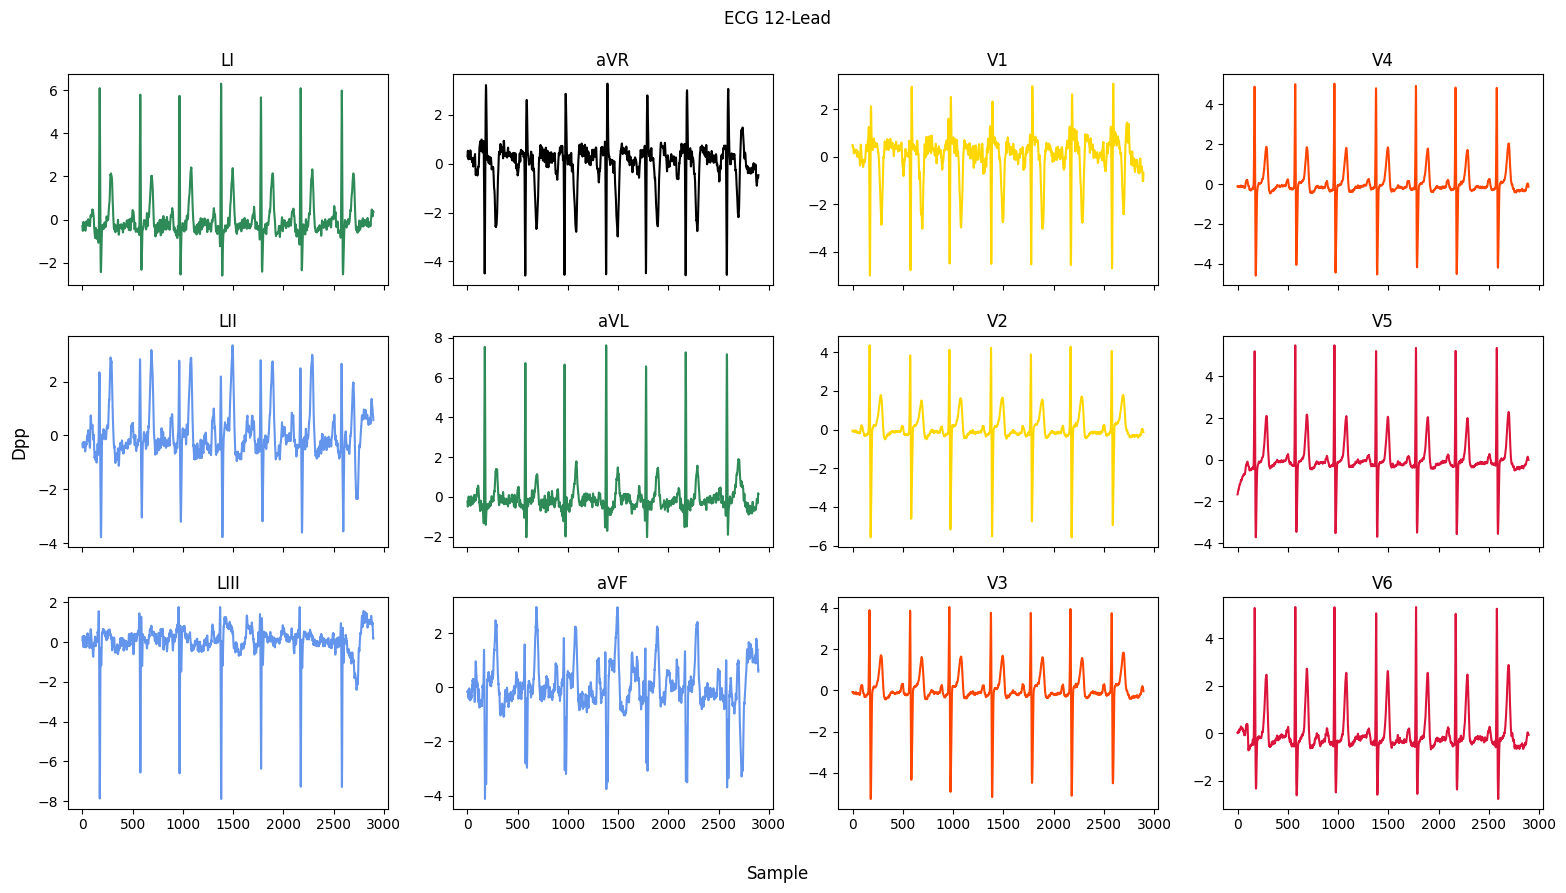

In [51]:
plotECG(
	ecg     = sampleECG,
	headers = ecgPlotHeaders,
	colors  = ecgPlotColors
)

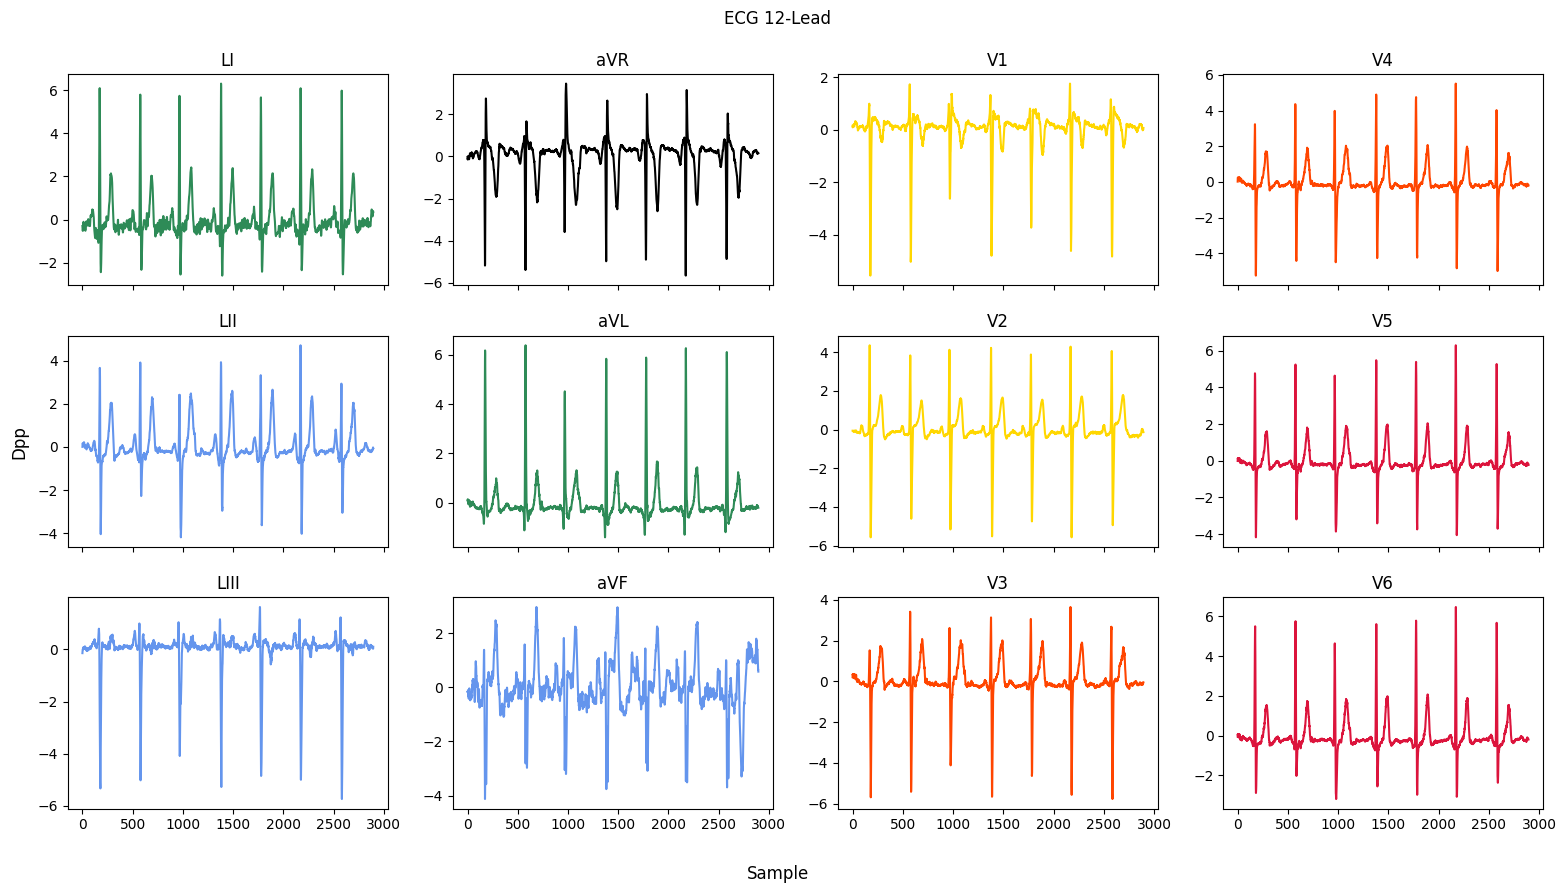

In [52]:
plotECG(
	ecg     = sampleECGReconstructed,
	headers = ecgPlotHeaders,
	colors  = ecgPlotColors
)

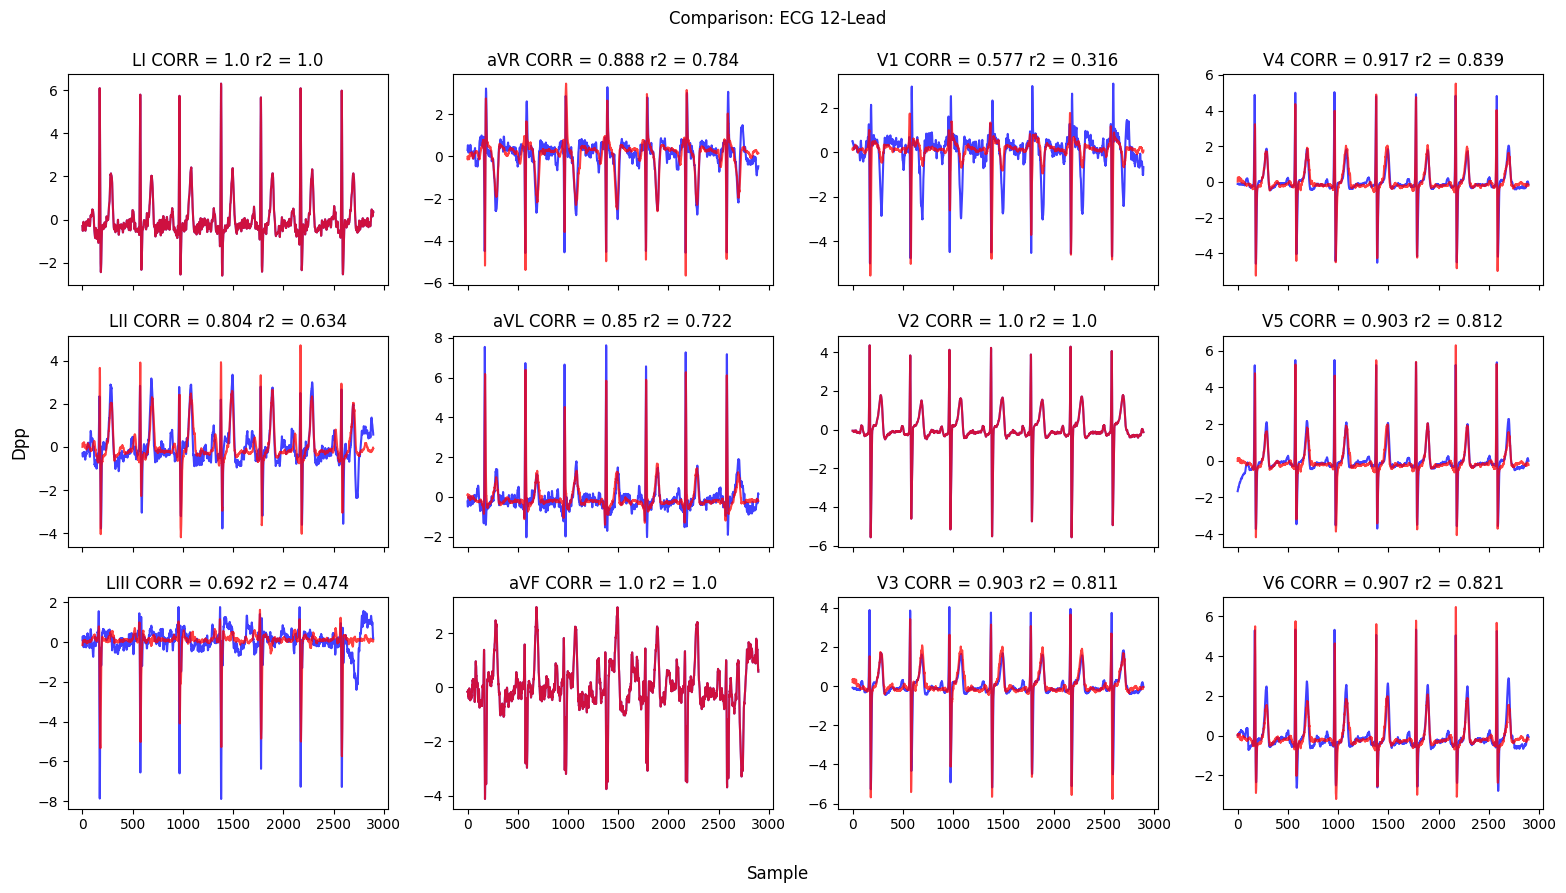

In [53]:
comparativeFullEcgPlot(
	ecgOring = sampleECG,
	ecgRec   = sampleECGReconstructed,
	headers  = ecgPlotHeaders
)

In [54]:
viewWindow = slice(1000, 2000)

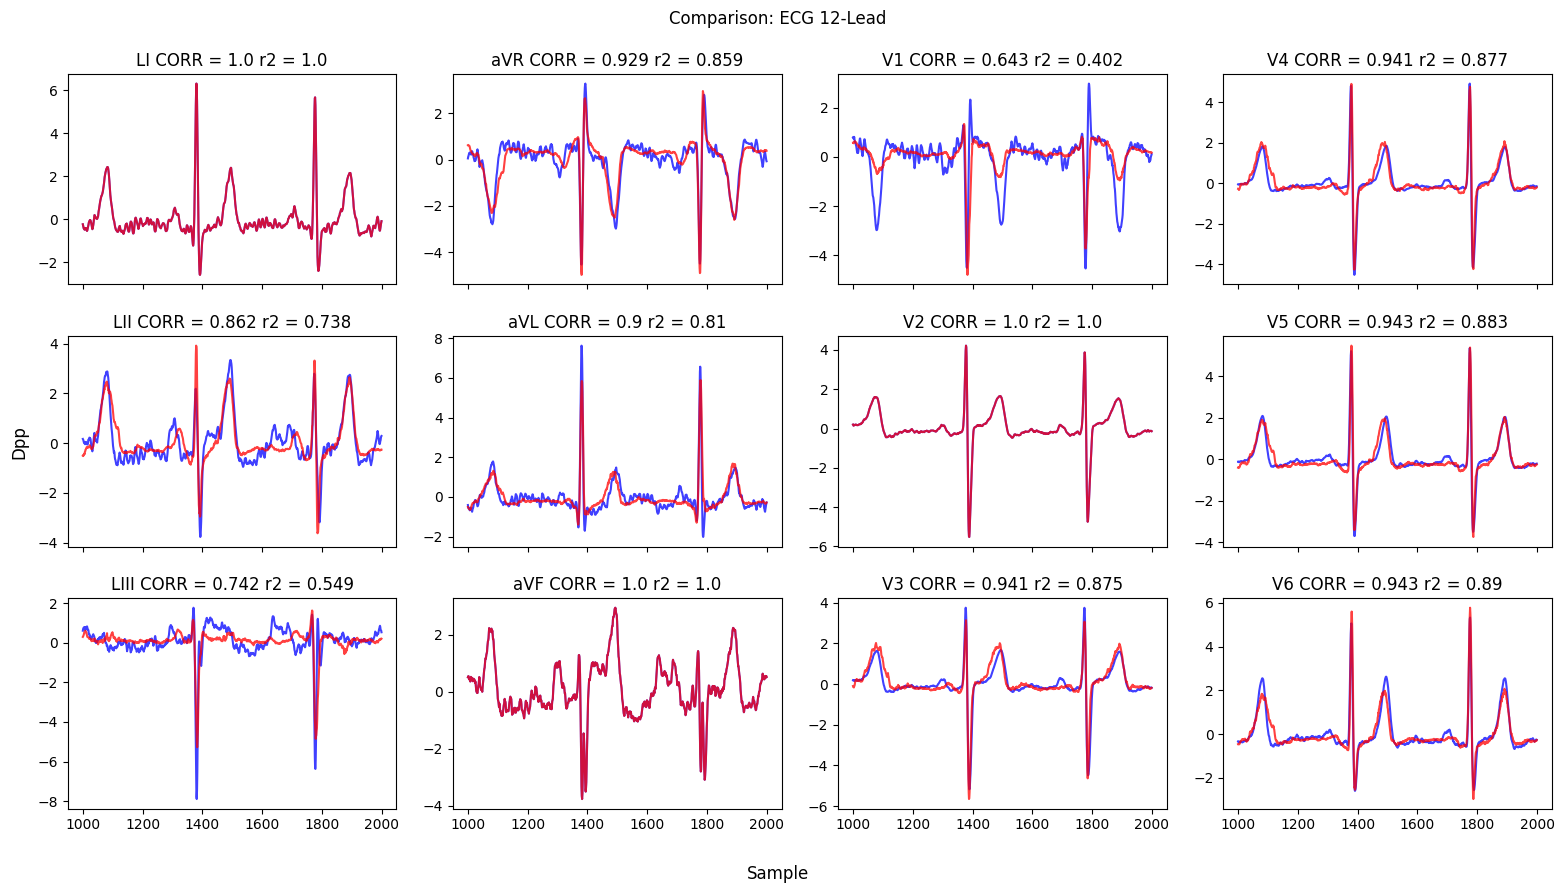

In [55]:
comparativeFullEcgPlot(
	ecgOring = sampleECG[viewWindow],
	ecgRec   = sampleECGReconstructed[viewWindow],
	headers  = ecgPlotHeaders
)

# Save model

In [56]:
torch.save(model.state_dict(), "../../../models/t2/ae-t2-v1.pth")